# Income Classification on Census Data

In this notebook we will build a binary classification pipeline to determine salary using Census data.

In [31]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.exceptions import NotFittedError
from sklearn.base import BaseEstimator, TransformerMixin, clone

from sklearn.model_selection import train_test_split as tts

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from yellowbrick.classifier import ClassificationReport

## Data Loading

Note that I've collected the data using the data management techniques I suggested last week.

In [2]:
names = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
]

data = pd.read_csv('data/adult.data', names=names)
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
class NanLabelEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, missing_string=' ?', replacement=np.nan):
        self.set_params(missing_string=missing_string, replacement=replacement)
    
    def fit(self, X, y=None):
        self.encoders_ = {
            col: LabelEncoder().fit(X[col])
            for col in X.columns
        }
        return self
    
    def transform(self, X):
        if not hasattr(self, "encoders_"):
            raise NotFittedError("please fit first!")
        
        Xp = []
        for col in X.columns:
            encoder = self.encoders_[col]
            colp = encoder.transform(X[col])
            if self.missing_string in encoder.classes_:
                label = np.where(encoder.classes_ == self.missing_string)[0][0]
                colp = np.where(colp==label, self.replacement, colp)
            Xp.append(pd.Series(colp, name=col))
        
        return pd.concat(Xp, axis=1)

In [5]:
class IdentityTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X

In [25]:
target_encoder = LabelEncoder()

X = data[[col for col in data.columns if col != 'income']]
y = target_encoder.fit_transform(data['income'])

remove = ['fnlwgt', 'education-num']
continuous = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical = [
    'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'
]

In [24]:
extractor = ColumnTransformer([
    ('encoder', Pipeline([
        ('nancode', NanLabelEncoder()),
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(categories='auto')),
    ]), categorical),
    ('dropper', ColumnTransformer([
        ('drop', 'drop', remove),
        ('keep', 'passthrough', continuous),
    ]), continuous+remove),
])

In [27]:
extractor.fit_transform(X, y).shape

(32561, 103)

In [29]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)

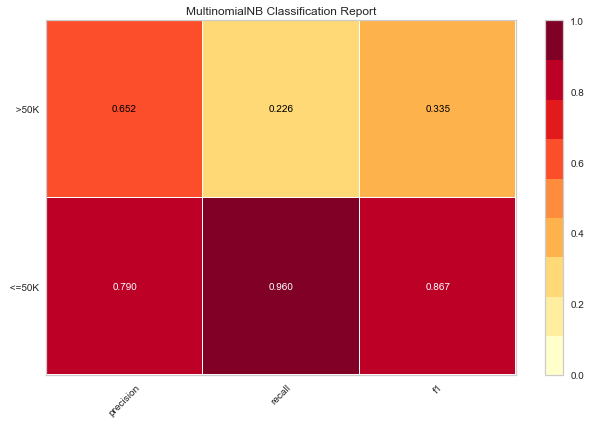

0.7778289574696761

In [38]:
def score_model(clf):
    _, ax = plt.subplots(figsize=(9,6))

    model = Pipeline([
        ('extract', clone(extractor)),
        ('clf', clone(clf)),
    ])

    cr = ClassificationReport(model, classes=target_encoder.classes_, ax=ax).fit(X_train, y_train)
    score = cr.score(X_test, y_test)
    cr.poof()
    return score


score_model(MultinomialNB())

/Users/benjamin/.pyenv/versions/3.7.3/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


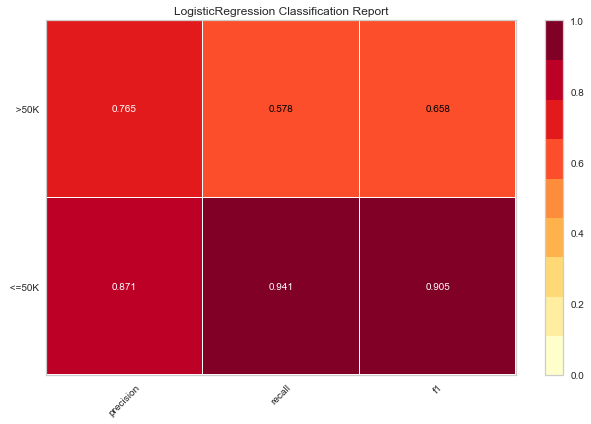

0.8510670965760786

In [39]:
score_model(LogisticRegression())

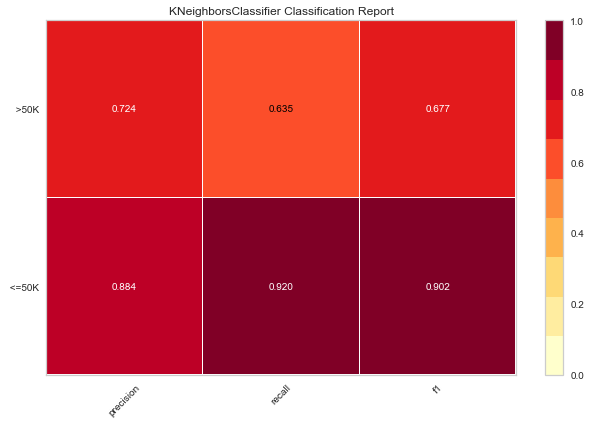

0.8493781667434362

In [40]:
score_model(KNeighborsClassifier())

/Users/benjamin/.pyenv/versions/3.7.3/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


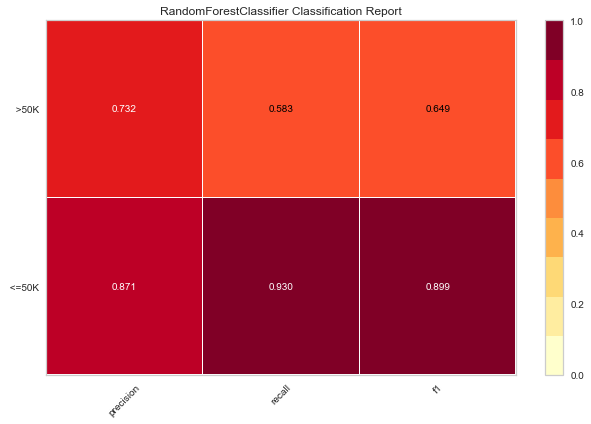

0.8435436818670352

In [41]:
score_model(RandomForestClassifier())